# DCEGM Upper Envelope
## ["The endogenous grid method for discrete-continuous dynamic choice models with (or without) taste shocks"](https://onlinelibrary.wiley.com/doi/abs/10.3982/QE643)

<p style="text-align: center;"><small><small><small>For the following badges: GitHub does not allow click-through redirects; right-click to get the link, then paste into navigation bar</small></small></small></p>

[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=notebooks%2FDCEGM-Upper-Envelope.ipynb)

[![Open in CoLab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb)



This notebook provides a simple introduction to the upper envelope calculation in the "DCEGM" algorithm <cite data-cite="6202365/4F64GG8F"></cite>. It takes the EGM method proposed in <cite data-cite="6202365/HQ6H9JEI"></cite>, and extends it to the mixed choice (discrete and continuous) case. It handles various constraints. It works on a 1-dimensional problems.

The main challenge in the types of models considered in DCEGM is, that the first order conditions to the Bellman equations are no longer sufficient to find an optimum.  Though, they are still necessary in a broad class of models. This means that our EGM step will give us (resource, consumption) pairs that do fulfill the FOCs, but that are sub-optimal (there's another consumption choices for the same initial resources that gives a higher value).

Take a consumption model formulated as:
$$
\max_{\{c_t\}^T_{t=1}} \sum^T_{t=1}\beta^t\cdot u(c_t)
$$
given some initial condition on $x$ and some laws of motion for the states, though explicit references to states are omitted. Then, if we're in a class of models described in EGM
, we can show that
$$
c_t = {u_{c}}^{-1}[E_t(u_c(c_{t+1}))]
$$
uniquely determines an optimal consumption today given the expected marginal utility of consuming  tomorrow. However, if there is a another choice in the choice set, and that choice is discrete, we get
$$
\max_{\{c_t, d_t\}^T_{t=1}} \sum^T_{t=1}\beta^t\cdot u(c_t, d_t)
$$
again given initial conditions and the laws of motion. Then, we can show that
$$
c_t = {u_{c}}^{-1}[E_t(u_c(c_{t+1}))]
$$
will produce solutions that are necessary but not sufficient. Note, that there is no explicit mentioning of the discrete choices in the expectation, but they obviously vary over the realized states in general. For the optimal consumption, it doesn't matter what the choice is exactly, only what expected marginal utility is tomorrow. The algorithm presented in [1] is designed to take advantage of models with this structure.

To visualize the problem, consider the following pictures that show the output of an EGM step from the model in the REMARK [linkhere].

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# here for now, should be
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp

def dcegmSegments(x, v):
    """
    Find index vectors `rise` and `fall` such that `rise` holds the indices `i`
    such that x[i+1]>x[i] and `fall` holds indices `j` such that either
    - x[j+1] < x[j] or,
    - x[j]>x[j-1] and v[j]<v[j-1].

    The vectors are essential to the DCEGM algorithm, as they definite the
    relevant intervals to be used to construct the upper envelope of potential
    solutions to the (necessary) first order conditions.

    Parameters
    ----------
    x : np.ndarray
        array of points where `v` is evaluated
    v : np.ndarray
        array of values of some function of `x`

    Returns
    -------
    rise : np.ndarray
        see description above
    fall : np.ndarray
        see description above
    """
    # NOTE: assumes that the first segment is in fact increasing (forced in EGM
    # by augmentation with the constrained segment).
    # elements in common grid g

    # Identify index intervals of falling and rising regions
    # We need these to construct the upper envelope because we need to discard
    # solutions from the inverted Euler equations that do not represent optimal
    # choices (the FOCs are only necessary in these models).
    #
    # `fall` is a vector of indices that represent the first elements in all
    # of the falling segments (the curve can potentially fold several times)
    fall = np.empty(0, dtype=int) # initialize with empty and then add the last point below while-loop

    rise = np.array([0]) # Initialize such thatthe lowest point is the first grid point
    i = 1 # Initialize
    while i <= len(x) - 2:
        # Check if the next (`ip1` stands for i plus 1) grid point is below the
        # current one, such that the line is folding back.
        ip1_falls = x[i+1] < x[i] # true if grid decreases on index increment
        i_rose = x[i] > x[i-1] # true if grid decreases on index decrement
        val_fell = v[i] < v[i-1] # true if value rises on index decrement

        if (ip1_falls and i_rose) or (val_fell and i_rose):

            # we are in a region where the endogenous grid is decreasing or
            # the value function rises by stepping back in the grid.
            fall = np.append(fall, i) # add the index to the vector

            # We now iterate from the current index onwards until we find point
            # where resources rises again. Unfortunately, we need to check
            # each points, as there can be multiple spells of falling endogenous
            # grids, so we cannot use bisection or some other fast algorithm.
            k = i
            while x[k+1] < x[k]:
                k = k + 1
            # k now holds either the next index the starts a new rising
            # region, or it holds the length of M, `m_len`.

            rise = np.append(rise, k)

            # Set the index to the point where resources again is rising
            i = k

        i = i + 1

    fall = np.append(fall, len(v)-1)

    return rise, fall
# think! nanargmax makes everythign super ugly because numpy changed the wraning
# in all nan slices to a valueerror...it's nans, aaarghgghg
def calcMultilineEnvelope(M, C, V_T, commonM):
    """
    Do the envelope step of the DCEGM algorithm. Takes in market ressources,
    consumption levels, and inverse values from the EGM step. These represent
    (m, c) pairs that solve the necessary first order conditions. This function
    calculates the optimal (m, c, v_t) pairs on the commonM grid.

    Parameters
    ----------
    M : np.array
        market ressources from EGM step
    C : np.array
        consumption from EGM step
    V_T : np.array
        transformed values at the EGM grid
    commonM : np.array
        common grid to do upper envelope calculations on

    Returns
    -------


    """
    m_len = len(commonM)
    rise, fall = dcegmSegments(M, V_T)

    # Add the last point to the vector for convenience below
    num_kinks = len(fall) # number of kinks / falling EGM grids

    # Use these segments to sequentially find upper envelopes. commonVARNAME
    # means the VARNAME evaluated on the common grid with a cloumn for each kink
    # discovered in dcegmSegments. This means that commonVARNAME is a matrix
    # common grid length-by-number of segments to consider. In the end, we'll
    # use nanargmax over the columns to pick out the best (transformed) values.
    # This is why we fill the arrays with np.nan's.
    commonV_T = np.empty((m_len, num_kinks))
    commonV_T[:] = np.nan
    commonC = np.empty((m_len, num_kinks))
    commonC[:] = np.nan

    # Now, loop over all segments as defined by the "kinks" or the combination
    # of "rise" and "fall" indices. These (rise[j], fall[j]) pairs define regions
    for j in range(num_kinks):
        # Find points in the common grid that are in the range of the points in
        # the interval defined by (rise[j], fall[j]).
        below = M[rise[j]] >= commonM # boolean array of bad indices below
        above = M[fall[j]] <= commonM # boolen array of bad indices above
        in_range = below + above == 0 # pick out elements that are neither

        # create range of indices in the input arrays
        idxs = range(rise[j], fall[j]+1)
        # grab ressource values at the relevant indices
        m_idx_j = M[idxs]

        # based in in_range, find the relevant ressource values to interpolate
        m_eval = commonM[in_range]

        # re-interpolate to common grid
        commonV_T[in_range,j] = LinearInterp(m_idx_j, V_T[idxs], lower_extrap=True)(m_eval)
        commonC[in_range,j]  = LinearInterp(m_idx_j, C[idxs], lower_extrap=True)(m_eval) # Interpolat econsumption also. May not be nesserary
    # for each row in the commonV_T matrix, see if all entries are np.nan. This
    # would mean that we have no valid value here, so we want to use this boolean
    # vector to filter out irrelevant entries of commonV_T.
    row_all_nan = np.array([np.all(np.isnan(row)) for row in commonV_T])
    # Now take the max of all these line segments.
    idx_max = np.zeros(commonM.size, dtype = int)
    idx_max[row_all_nan == False] = np.nanargmax(commonV_T[row_all_nan == False], axis=1)

    # prefix with upper for variable that are "upper enveloped"
    upperV_T = np.zeros(m_len)

    # Set the non-nan rows to the maximum over columns
    upperV_T[row_all_nan == False] = np.nanmax(commonV_T[row_all_nan == False, :], axis=1)
    # Set the rest to nan
    upperV_T[row_all_nan] = np.nan

    # Add the zero point in the bottom
    if np.isnan(upperV_T[0]):
        # in transformed space space, utility of zero-consumption (-inf) is 0.0
        upperV_T[0] = 0.0
        # commonM[0] is typically 0, so this is safe, but maybe it should be 0.0
        commonC[0]  = commonM[0]

    # Extrapolate if NaNs are introduced due to the common grid
    # going outside all the sub-line segments
    IsNaN = np.isnan(upperV_T)
    upperV_T[IsNaN] = LinearInterp(commonM[IsNaN == False], upperV_T[IsNaN == False])(commonM[IsNaN])


    LastBeforeNaN = np.append(np.diff(IsNaN)>0, 0)
    LastId = LastBeforeNaN*idx_max # Find last id-number
    idx_max[IsNaN] = LastId[IsNaN]
    # Linear index used to get optimal consumption based on "id"  from max
    ncols = commonC.shape[1]
    rowidx = np.cumsum(ncols*np.ones(len(commonM), dtype=int))-ncols
    idx_linear = np.unravel_index(rowidx+idx_max, commonC.shape)
    upperC = commonC[idx_linear]
    upperC[IsNaN] = LinearInterp(commonM[IsNaN==0], upperC[IsNaN==0])(commonM[IsNaN])

    # TODO calculate cross points of line segments to get the true vertical drops

    upperM = commonM.copy() # anticipate this TODO

    return upperM, upperC, upperV_T


In [3]:
m_common = np.linspace(0,1.0,100)
m_egm = np.array([0.0, 0.04, 0.25, 0.15, 0.1, 0.3, 0.6,0.5, 0.35, 0.6, 0.75,0.85])
c_egm = np.array([0.0, 0.03, 0.1, 0.07, 0.05, 0.36, 0.4, 0.6, 0.8, 0.9,0.9,0.9])
vt_egm = np.array( [0.0, 0.05, 0.1,0.04, 0.02,0.2, 0.7, 0.5, 0.2, 0.9, 1.0, 1.2])

Text(0,0.5,'transformed values')

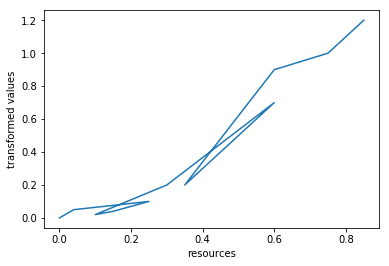

In [4]:
plt.plot(m_egm, vt_egm)
plt.xlabel("resources")
plt.ylabel("transformed values")

Text(0,0.5,'consumption')

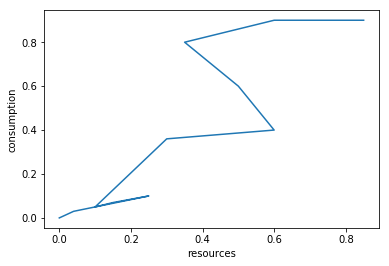

In [5]:
plt.plot(m_egm, c_egm)
plt.xlabel("resources")
plt.ylabel("consumption")

The point of DCEGM is to realize, that the segments on the `(m, vt)` curve that are decreasing, cannot be optimal. This leaves us with a set of increasing line segments, as seen below (`dcegmSegments` is the function in HARK that calculates the breaks where the curve goes from increasing to decreasing).

In [6]:
rise, fall = dcegmSegments(m_egm, vt_egm)

In `rise` we have all the starting indices for the segments that are "good", that is `(m, vt)` draws an increasing curve.

In [7]:
rise

array([0, 4, 8])

We see that `rise` has its first index at `0`, then again at `4`, and lastly at `8`. Let's look at `fall`.

In [8]:
fall

array([ 2,  6, 11])

We see that the last segment is increasing (as the last element of `rise` is larger than the last element of `fall`), and we see that `len(fall)` is one larger than number of problematic segments in the plot. The index of the last point in `m_egm`/`c_egm`/`vt_egm` is added for convenience when we do the upper envelope step (and is also convenient below for drawing the segments!).

We can use `fall` and `rise` to draw only the relevant segments that we will use to construct an upper envelope.

Text(0,0.5,'transformed values')

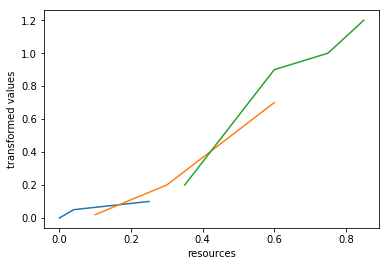

In [9]:
for j in range(len(fall)):
    idx = range(rise[j],fall[j]+1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.xlabel("resources")
plt.ylabel("transformed values")

Let us now use the `calcMultilineEnvelope` function to do the full DCEGM step: find segments and calculate upper envelope in one sweep.

In [10]:
m_upper, c_upper, v_upper = calcMultilineEnvelope(m_egm, c_egm, vt_egm, m_common)

Text(0,0.5,'transformed values')

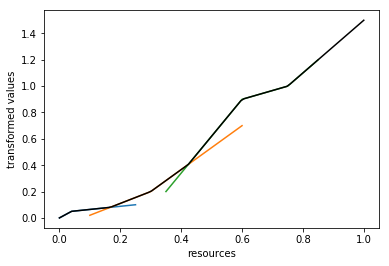

In [11]:
for j in range(len(fall)):
    idx = range(rise[j],fall[j]+1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.plot(m_upper, v_upper, 'k')
plt.xlabel("resources")
plt.ylabel("transformed values")

And there we have it! These functions are the building blocks for univariate discrete choice modeling in HARK, so hopefully this little demo helped better understand what goes on under the hood, or it was a help if you're extending some existing class with a discrete choice.

# References
[1] Iskhakov, F. , Jørgensen, T. H., Rust, J. and Schjerning, B. (2017), The endogenous grid method for discrete‐continuous dynamic choice models with (or without) taste shocks. Quantitative Economics, 8: 317-365. doi:10.3982/QE643

[2] Carroll, C. D. (2006). The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics letters, 91(3), 312-320.

